In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

In [2]:
def dataframe_to_train_test_tensors(df, target, train_rate=0.9, shuffle=True):
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)

    x_df = df.drop(columns=[target])
    y_df = df[[target]]
    
    train_size = int(train_rate * len(df))
    
    x_train = torch.tensor(x_df.iloc[:train_size].values, dtype=torch.float64)
    y_train = torch.tensor(y_df.iloc[:train_size].values, dtype=torch.float64)
    x_test = torch.tensor(x_df.iloc[train_size:].values, dtype=torch.float64)
    y_test = torch.tensor(y_df.iloc[train_size:].values, dtype=torch.float64)

    return x_train, y_train, x_test, y_test

In [3]:
df = pd.read_csv('data/1ao_2rs_f.csv').dropna()

In [4]:
x_train, y_train = dataframe_to_train_test_tensors(df, 'is_identical', train_rate=1.0, shuffle=True)[:2]

In [5]:
class TwoLayersNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TwoLayersNN, self).__init__()
        
        self.fc1 = torch.nn.Linear(input_size, input_size).double()
        self.fc2 = torch.nn.Linear(input_size, output_size).double()

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        return out

    def print(self):
        print(self.fc1)

In [24]:
config = dict(
    n_epochs=15000,
    learning_rate=0.001,
    weight_decay=0.01,
    target_loss=0.0001
)

In [25]:
model = TwoLayersNN(input_size=x_train.shape[1], output_size=y_train.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
criterion = torch.nn.MSELoss()

In [26]:
losses = []
lrs = []
progressbar = trange(config["n_epochs"])
for epoch in progressbar:
    progressbar.set_description(f'Epoch {epoch+1}')
        
    output = model(x_train)
    loss = criterion(output, y_train)
        
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(optimizer.param_groups[0]['params'], 10**10)
    optimizer.step()
    optimizer.zero_grad()
        
    lrs.append(optimizer.param_groups[0]['lr'])
    losses.append(loss.item())

    progressbar.set_postfix({'loss': loss.item()})

        # scheduler.step()
        # data_fold_width = 100/
        # if epoch % data_fold_width == data_fold_width - 1 and np.std(losses[-data_fold_width:]) / np.mean(losses[-data_fold_width:]) < 0.025:
            # print(optimizer.param_groups[0]['lr'], end=' -> ')
            # optimizer.param_groups[0]['lr'] *= 0.5
            # print(optimizer.param_groups[0]['lr'])

    if loss.item() < config["target_loss"]:
        break

  0%|          | 0/15000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



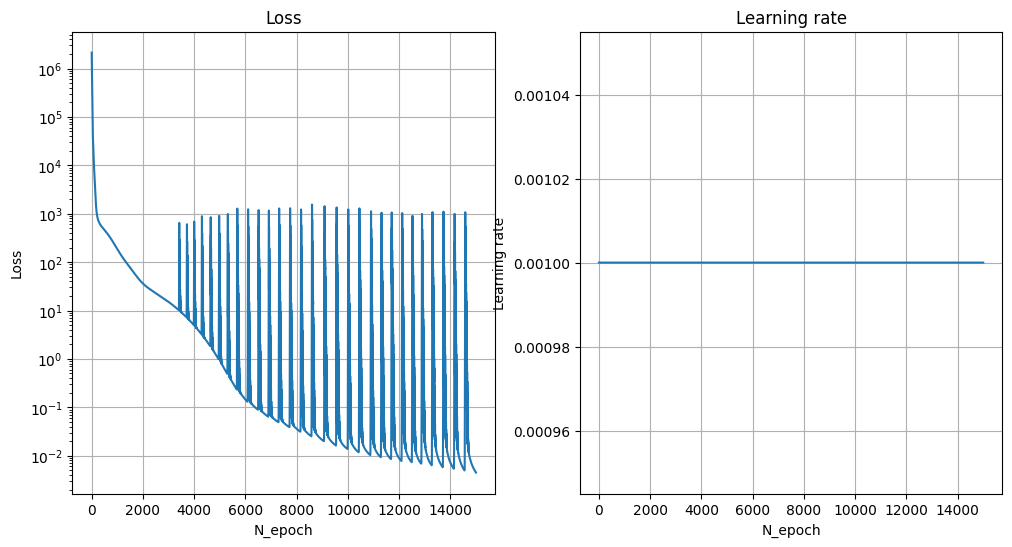

In [27]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Loss plot
axis[0].set_title("Loss")
axis[0].set_xlabel("N_epoch")
axis[0].set_ylabel("Loss")
axis[0].semilogy()
axis[0].grid()
axis[0].plot(losses)

# Learning rate plot
axis[1].set_title("Learning rate")
axis[1].set_xlabel("N_epoch")
axis[1].set_ylabel("Learning rate")
axis[1].grid()
axis[1].plot(lrs)

In [28]:
with torch.no_grad():
    print(f'Train loss : {criterion(model(x_train), y_train)}')

Train loss : 0.00447217340680582


In [29]:
df_g = pd.read_csv('data/1ao_2rs_g.csv')
x_test_g, y_test_g = dataframe_to_train_test_tensors(df_g, 'is_identical', train_rate=0.0, shuffle=True)[2:]

In [30]:
with torch.no_grad():
    print(f'Test loss on new system : {criterion(model(x_test_g), y_test_g)}')

Test loss on new system : nan


In [31]:
df_h = pd.read_csv('data/1ao_2rs_h.csv')
x_test_h, y_test_h = dataframe_to_train_test_tensors(df_h, 'is_identical', train_rate=0.0, shuffle=True)[2:]

In [32]:
with torch.no_grad():
    print(f'Test loss on new system : {criterion(model(x_test_h), y_test_h)}')

Test loss on new system : nan
